In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline  
import plotly.offline as po
import plotly.graph_objs as go

po.init_notebook_mode(connected=True)

from copy import deepcopy

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [32]:
original_data = pd.read_csv("data.csv", parse_dates = ['Date'])

df = deepcopy(original_data)

In [33]:
df = df[df["Region"] == "us"][df["Track Name"] == "Shape of You"]
df_cut = df[df['Date'] >= datetime(2017, 6, 3)][df['Date'] < datetime(2017, 12, 1)]

trace = go.Scatter(x = df_cut['Date'], y = df_cut['Streams'], name = 'Shape of You')
po.iplot(go.Figure([trace]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [65]:
train = pd.DataFrame(df_cut.iloc[0:int(0.9 * len(df_cut)), :]['Streams'])
test =  pd.DataFrame(df_cut.iloc[int(0.9 * len(df_cut)):, ]['Streams'])

print(train.shape)
print(test.shape)

train.index = pd.DatetimeIndex(freq = 'd', start = datetime(2017, 6, 3), periods = train.shape[0])

(162, 1)
(19, 1)


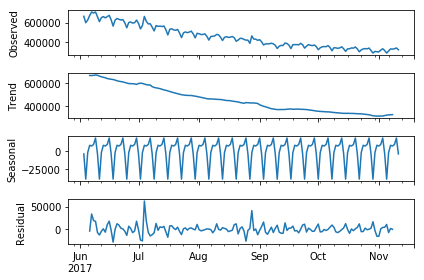

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train)
fig = result.plot()

In [67]:
def difference(dataset, season_offset):
    diff = list()
    for i in range(season_offset, len(dataset)):
        value = dataset[i] - dataset[i - season_offset]
        diff.append(value)
    return pd.Series(diff)

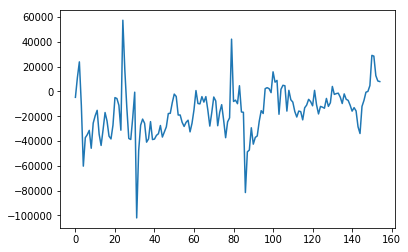

In [68]:
# Remove seasonal difference, season length is 7 according to our observation in Level 4 - Story
train_no_season = difference(train['Streams'], 7)
plt.plot(train_no_season)

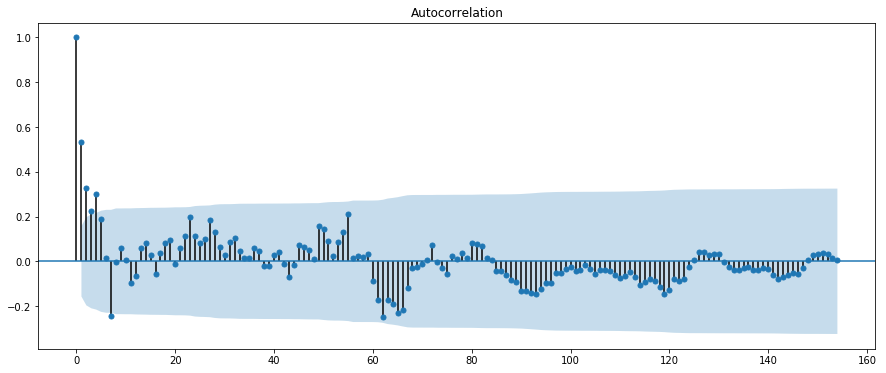

In [69]:
plt.figure(figsize = (15, 6))
plot_acf(train_no_season, ax=plt.gca())
plt.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



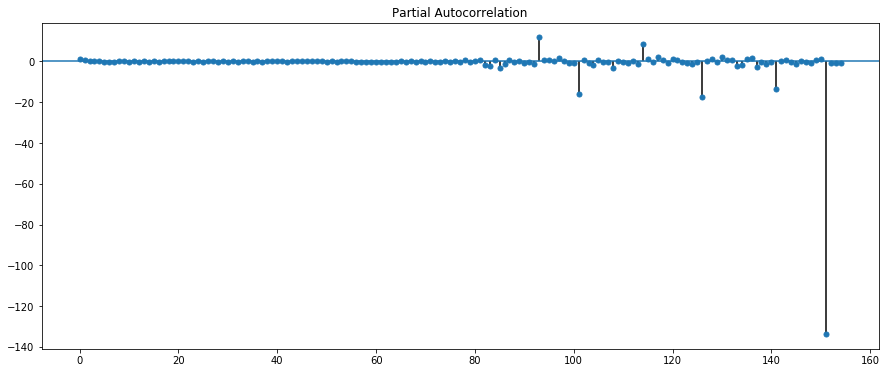

In [70]:
plt.figure(figsize = (15, 6))
plot_pacf(train_no_season, ax=plt.gca())
plt.show()

In [71]:
train['Streams'] = train['Streams'].astype('float64')
test['Streams'] = test['Streams'].astype('float32')

model = ARIMA(train_no_season, order=(0, 0, 7))
model_fit = model.fit()
predict = model_fit.predict(start = 0, end = len(test) - 1)


In [72]:
print(model_fit.summary().as_text)

<bound method Summary.as_text of <class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  155
Model:                     ARMA(0, 7)   Log Likelihood               -1689.882
Method:                       css-mle   S.D. of innovations          12770.654
Date:                Thu, 24 Jan 2019   AIC                           3397.764
Time:                        00:11:25   BIC                           3425.154
Sample:                             0   HQIC                          3408.889
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.401e+04   3326.985     -4.210      0.000   -2.05e+04   -7484.758
ma.L1.y        0.6469      0.085      7.597      0

In [73]:
def add_back(train, train_no_season, predict, offset):
    diff = train[0:offset] + train_no_season + predict
    for i in range(offset, len(diff)):
        diff[i] = diff[i] + diff[i - offset]
    return diff

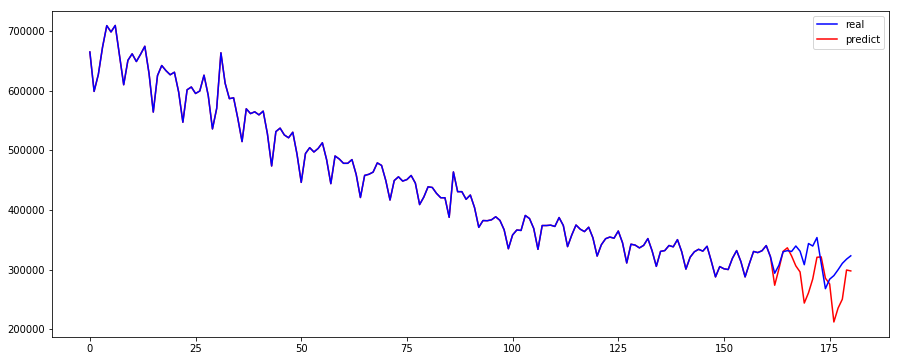

In [74]:
predict_value = add_back(list(train['Streams']), list(train_no_season), list(predict), 7)
plt.figure(figsize = (15, 6))
predict_trace, = plt.plot(predict_value, color = 'red')
real_trace, = plt.plot(list(df_cut['Streams']), color = 'blue')
plt.legend(handles = [real_trace, predict_trace,], labels = ['real', 'predict'], loc = 'best')